# ISIC2019



Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import sys
import time
import gc
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import copy
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

from efficientnet_pytorch import EfficientNet

In [2]:
sys.path.append('..')

from utils.train import train
from utils.metrics import get_scores, get_metrics
from utils.dataset import get_data_loader

# Models

In [3]:
class BaseMetaModel(nn.Module):

    def __init__(self, model):

        super().__init__()
        self.model  = model

    def forward(self, img, metadata):
        return self.model(img)

In [4]:
def get_model(model_name, n_classes=8, pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model      = None
    input_size = 0
    weights    = None

    if 'resnet' in model_name:
        model_n = model_name[6:]
        if pretrained:
            weights = f'ResNet{model_n}_Weights.DEFAULT'

        if model_name == 'resnet18':
            model = models.resnet18(weights=weights)
        elif model_name == 'resnet34':
            model = models.resnet34(weights=weights)
        elif model_name == 'resnet50':
            model = models.resnet50(weights=weights)
        elif model_name == 'resnet101':
            model = models.resnet101(weights=weights)
        elif model_name == 'resnet152':
            model = models.resnet152(weights=weights)
        else:
            raise Exception('Resnet model must be resnet18, resnet34, resnet50, resnet101 or resnet152')

        n_feats = model.fc.in_features
        input_size     = 224
        model.fc       = nn.Linear(n_feats, n_classes)
        

    elif 'effnet' in model_name:
        model_n = model_name[-1]
        full_model_name = f'efficientnet-b{model_n}'

        if pretrained:
            model = EfficientNet.from_pretrained(full_model_name, num_classes=n_classes)
        else:
            model = EfficientNet.from_name(full_model_name, num_classes=n_classes)

        n_feats = model._fc.in_features
        input_size     = EfficientNet.get_image_size(full_model_name)


    elif model_name == 'alexnet':
        if pretrained:
            weights = 'AlexNet_Weights.DEFAULT'
        model = models.alexnet(weights=weights)

        n_feats      = model.classifier[6].in_features
        input_size          = 224
        model.classifier[6] = nn.Linear(n_feats, n_classes)

    elif 'vit' in model_name:
        vit_type = model_name[4]
        vit_num  = model_name[6:8]
        if pretrained:
            weights = f'ViT_{vit_type.upper()}_{vit_num}_Weights.IMAGENET1K_V1'

        if model_name == 'vit_b_16':
            model = models.vit_b_16(weights=weights)
        elif model_name == 'vit_b_32':
            model = models.vit_b_32(weights=weights)
        elif model_name == 'vit_l_16':
            model = models.vit_l_16(weights=weights)
        elif model_name == 'vit_l_32':
            model = models.vit_l_32(weights=weights)
        elif model_name == 'vit_h_14':
            weights = 'DEFAULT'
            model = models.vit_h_14(weights=weights)
        else:
            raise Exception('ViT model must be vit_b_16, vit_b_32, vit_l_16, vit_l_32, or vit_h_14')

        n_feats          = model.hidden_dim
        model.heads.head = nn.Linear(n_feats, n_classes)
        input_size = 224
        
    else:
        print('Invalid model name, exiting...')
        exit()

    model.name           = model_name
    model.n_feats        = n_feats
    model.input_size     = input_size

    return model

# Dataset

In [5]:
df = pd.read_csv('train_metadata.csv')
df

,image,diagnostic,age_approx,female,male,anterior_torso,head_neck,lateral_torso,lower_extremity,oral_genital,palms_soles,posterior_torso,upper_extremity,diagnostic_number,folder
0,ISIC_0000000,NV,55.0,1,0,1,0,0,0,0,0,0,0,5,0
1,ISIC_0000001,NV,30.0,1,0,1,0,0,0,0,0,0,0,5,1
2,ISIC_0000002,MEL,60.0,1,0,0,0,0,0,0,0,0,1,4,2
3,ISIC_0000003,NV,30.0,0,1,0,0,0,0,0,0,0,1,5,3
4,ISIC_0000004,MEL,80.0,0,1,0,0,0,0,0,0,1,0,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,BCC,85.0,1,0,0,1,0,0,0,0,0,0,1,26
25327,ISIC_0073248,BKL,65.0,0,1,1,0,0,0,0,0,0,0,2,27
25328,ISIC_0073249,MEL,70.0,0,1,0,0,0,1,0,0,0,0,4,28
25329,ISIC_0073251,NV,55.0,1,0,0,0,0,0,0,1,0,0,5,29


In [6]:
open_file = open('train_idcs', "rb")
train_folds = pickle.load(open_file)
open_file.close()

open_file = open('val_idcs', "rb")
val_folds = pickle.load(open_file)
open_file.close()

open_file = open('test_idcs', "rb")
test_idcs = pickle.load(open_file)
open_file.close()

# Training

In [7]:
torch.cuda.device_count()

4

In [8]:
# model_names = ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'effnetb0', 'effnetb1',
#                'effnetb2', 'effnetb3', 'effnetb4', 'effnetb5']

In [9]:
# model_names = ['effnetb4', 'effnetb5']

In [10]:
data_dir  = 'imgs/ISIC_2019_Training_Input'
age_cols = ['age_approx']
sex_cols = ['female', 'male']
loc_cols = ['anterior_torso', 'head_neck', "lateral_torso", 'lower_extremity', 'oral_genital',
            'palms_soles', 'posterior_torso',  'upper_extremity']

metadata_cols = age_cols + sex_cols + loc_cols

batch_size    = 32
num_workers   = 16
input_size    = 224

train_transform = transforms.Compose([transforms.RandomResizedCrop(input_size),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_transform   = transforms.Compose([transforms.Resize((input_size, input_size)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [11]:
#n_classes = len(set(train_labels))
n_epochs  = 150


lr        = 1e-3 # Learning rate
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

n_samples = df.diagnostic_number.value_counts().sort_index().values

weights = [1 - (x / sum(n_samples)) for x in n_samples]
weights = torch.FloatTensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight=weights).to(device)

saved_models_folder = 'saved_basemodels'
saved_scores_folder = 'saved_basescores'

cuda


In [13]:
#model_names = ['vit_b_16', 'vit_b_32', 'vit_l_16', 'vit_l_32']
model_names = ['vit_b_32', 'vit_l_32']

In [14]:
#folds = [0, 1, 2, 3, 4]
folds = [1, 2, 3, 4]

for fold in folds:
    
    # Dataloaders
    train_idcs = train_folds[fold]
    val_idcs   = val_folds[fold]
    train_imgs = df.loc[train_idcs, 'image'].values
    val_imgs   = df.loc[val_idcs, 'image'].values
    test_imgs  = df.loc[test_idcs, 'image'].values

    train_paths = [f'{os.path.join(data_dir, img)}.jpg' for img in train_imgs]
    val_paths   = [f'{os.path.join(data_dir, img)}.jpg' for img in val_imgs]
    test_paths  = [f'{os.path.join(data_dir, img)}.jpg' for img in test_imgs]
    
    train_labels = df.loc[train_idcs, 'diagnostic_number'].values
    val_labels   = df.loc[val_idcs,   'diagnostic_number'].values
    test_labels  = df.loc[test_idcs,  'diagnostic_number'].values
    
    train_metadata = df.loc[train_idcs, metadata_cols].values
    val_metadata   = df.loc[val_idcs, metadata_cols].values
    test_metadata  = df.loc[test_idcs, metadata_cols].values
    train_dataloader = get_data_loader(train_paths, train_labels, metadata=train_metadata, transform=train_transform, batch_size=batch_size, num_workers=num_workers)
    val_dataloader   = get_data_loader(val_paths, val_labels, metadata=val_metadata, transform=val_transform, batch_size=batch_size, num_workers=num_workers)
    test_dataloader  = get_data_loader(test_paths, test_labels, metadata=test_metadata, transform=val_transform, batch_size=batch_size, num_workers=num_workers) 
    
    # Training
    n_classes = len(set(train_labels))
    for model_name in model_names:
        print(f'{"*"*89}\n{model_name.upper()}\n{"*"*89}\n')
        save_path = f'base_{model_name}_w_{fold}'

        model = BaseMetaModel(get_model(model_name, n_classes=n_classes, pretrained=True)).to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=7)

        train(model, train_dataloader, val_dataloader, optimizer, scheduler, criterion, device, n_epochs,
          saved_models_folder, saved_scores_folder, save_path, printfreq=5)

        del model
        gc.collect()
        torch.cuda.empty_cache()

*****************************************************************************************
VIT_B_32
*****************************************************************************************

 Epoch    Train Loss    Val Loss    Train Acc    Val Acc    Best      lr      Time [min]
-----------------------------------------------------------------------------------------
     5      0.8463       0.9539       0.7222      0.7020     ***    1.0e-03       0.7
    10      0.6764       1.0527       0.7758      0.7118            1.0e-03       0.7
    15      0.4227       1.0213       0.8626      0.7259            1.0e-04       0.7
    20      0.3688       1.0325       0.8765      0.7246            1.0e-04       0.7
Training stopped early
-----------------------------------------------------------------------------------------
Total time [min] for 20 Epochs: 15.5
*****************************************************************************************
VIT_L_32
**************************************

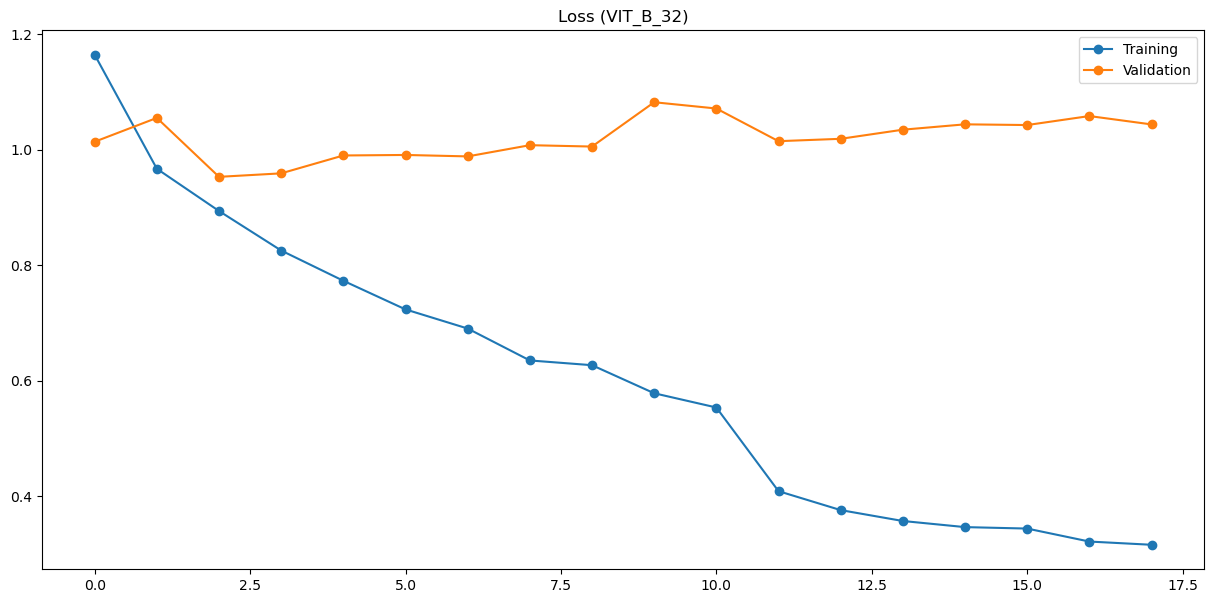

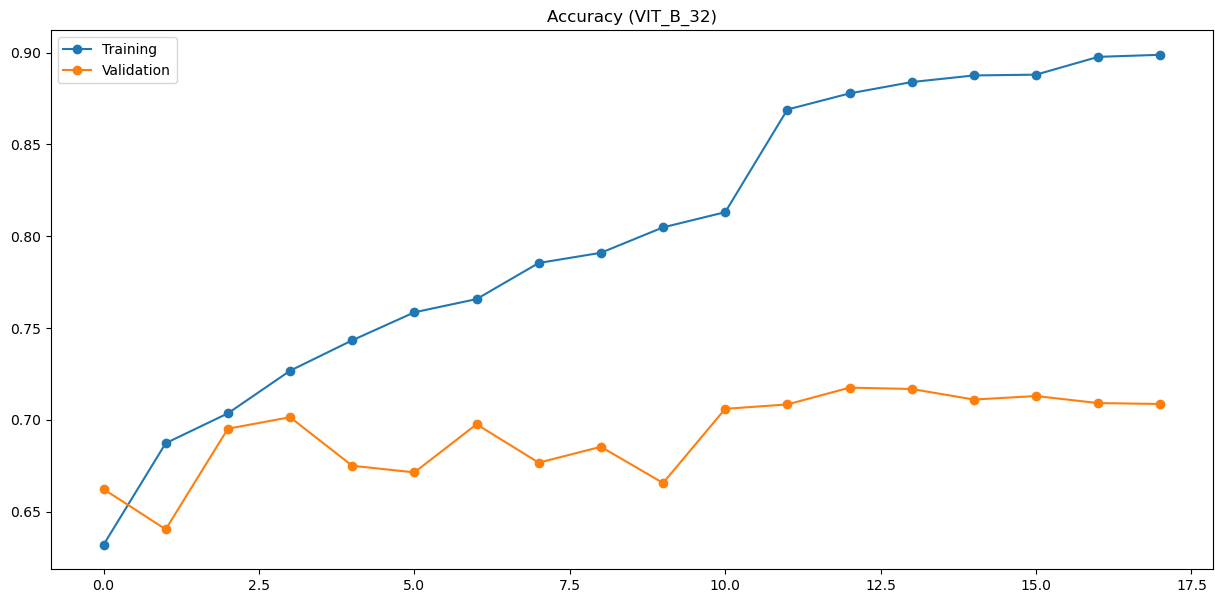

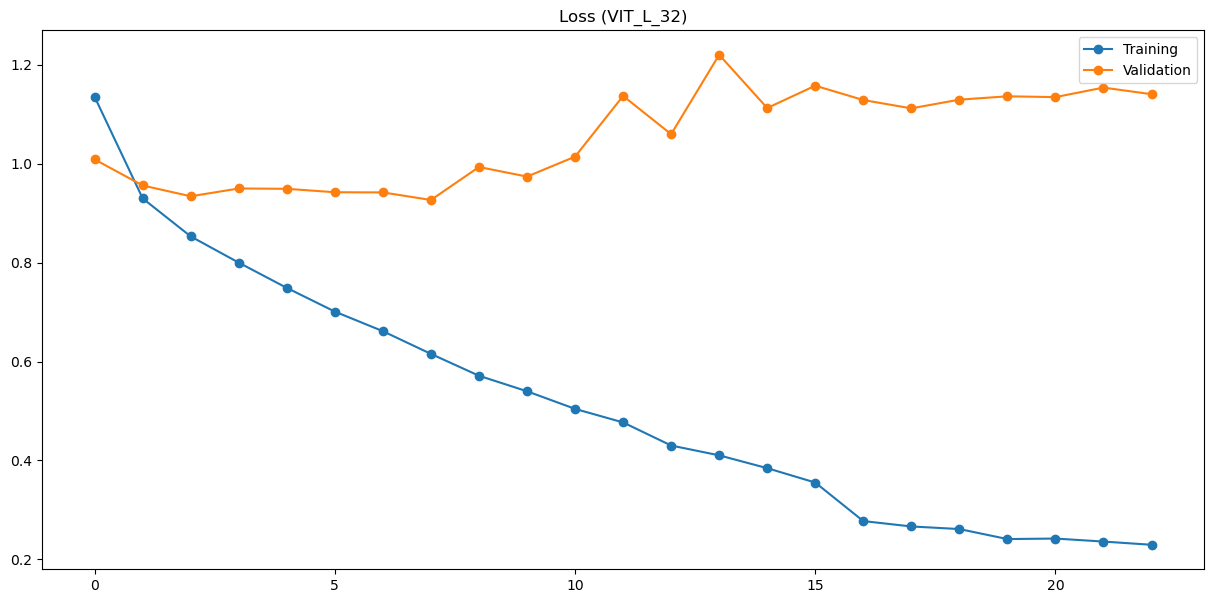

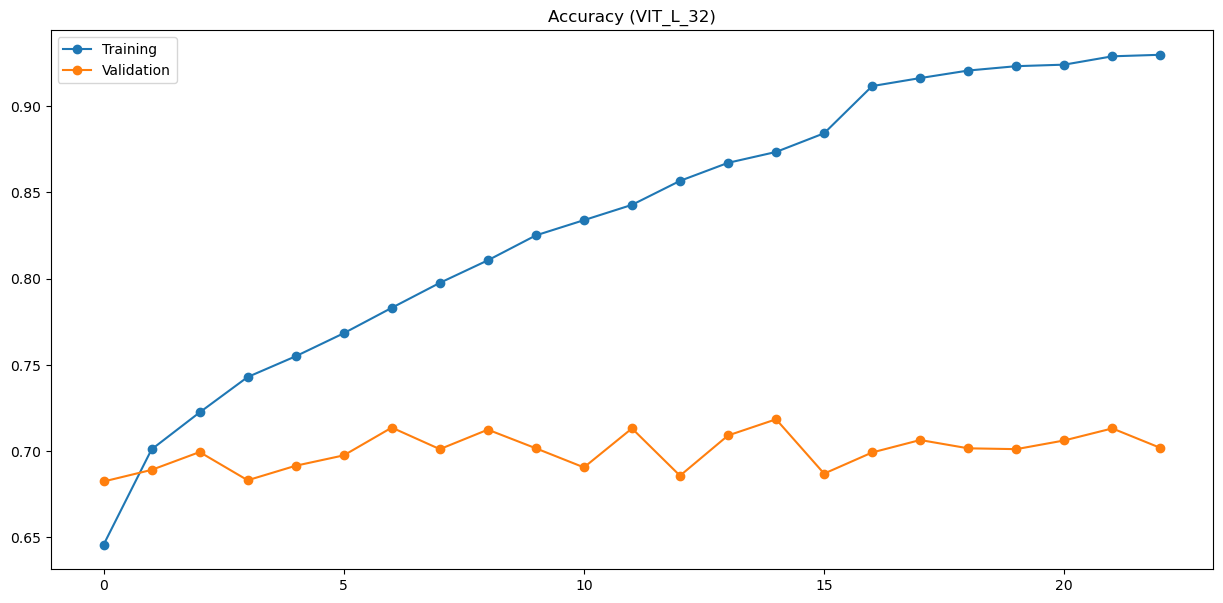

In [15]:
for model_name in model_names:
    #print(f'{"*"*79}\n{model_name.upper()}\n{"*"*79}\n\n')
    
    save_path = f'base_{model_name}_w_0'
    # Loss
    train_loss_hist = np.load(os.path.join(saved_scores_folder, f'{save_path}_train_loss.npy'))
    val_loss_hist   = np.load(os.path.join(saved_scores_folder, f'{save_path}_val_loss.npy'))

    # Acc
    train_acc_hist = np.load(os.path.join(saved_scores_folder, f'{save_path}_train_acc.npy'))
    val_acc_hist   = np.load(os.path.join(saved_scores_folder, f'{save_path}_val_acc.npy'))

    epochs = range(len(train_loss_hist))

    plt.plot(epochs, train_loss_hist, marker='o', label='Training')
    plt.plot(epochs, val_loss_hist, marker='o', label='Validation')
    plt.title(f'Loss ({model_name.upper()})')
    plt.legend()
    plt.show()

    plt.plot(epochs, train_acc_hist, marker='o', label='Training')
    plt.plot(epochs, val_acc_hist, marker='o', label='Validation')
    plt.title(f'Accuracy ({model_name.upper()})')
    plt.legend()
    plt.show()

# Testing

In [16]:
data_dir  = 'imgs/ISIC_2019_Training_Input'
age_cols = ['age_approx']
sex_cols = ['female', 'male']
loc_cols = ['anterior_torso', 'head_neck', "lateral_torso", 'lower_extremity', 'oral_genital',
            'palms_soles', 'posterior_torso',  'upper_extremity']

metadata_cols = age_cols + sex_cols + loc_cols

batch_size    = 32
num_workers   = 16
input_size    = 224

train_transform = transforms.Compose([transforms.RandomResizedCrop(input_size),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_transform   = transforms.Compose([transforms.Resize((input_size, input_size)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [17]:
# Dataloaders

test_imgs  = df.loc[test_idcs, 'image'].values

test_paths  = [f'{os.path.join(data_dir, img)}.jpg' for img in test_imgs]

test_labels  = df.loc[test_idcs,  'diagnostic_number'].values


test_metadata  = df.loc[test_idcs, metadata_cols].values
test_dataloader  = get_data_loader(test_paths, test_labels, metadata=test_metadata, transform=val_transform, batch_size=batch_size, num_workers=num_workers) 


In [18]:
# model_names = ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'effnetb0', 'effnetb1',
#                'effnetb2', 'effnetb3', 'effnetb4', 'effnetb5']

# test_dataloader  = get_data_loader(test_paths, test_labels, metadata=test_metadata, transform=val_transform, batch_size=batch_size, num_workers=num_workers) 
# n_classes = 8#len(set(train_labels))
# print(n_classes)
# device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# saved_models_folder = 'saved_basemodels'
# saved_scores_folder = 'saved_basescores'

# folds = [0]
# # folds = [0, 1, 2, 3, 4]

# for fold in folds:
#     print(f'{"*"*79}\n{fold}\n{"*"*79}\n')
#     all_metrics_dict = dict()
#     for model_name in model_names:
#         #print(f'{"*"*79}\n{model_name.upper()}\n{"*"*79}\n')
#         save_path = f'best_base_{model_name}_w_{fold}'

#         model = BaseMetaModel(get_model(model_name, n_classes=n_classes, pretrained=True)).to(device)
#         model.load_state_dict(torch.load(os.path.join(saved_models_folder, save_path)))

#         y_true, y_prob, y_pred = get_scores(model, test_dataloader, batch_size, device)
#         metrics_dict = get_metrics(y_true, y_prob, y_pred)
#         all_metrics_dict[model_name] = metrics_dict

#         #print(metrics_dict)
#     display(pd.DataFrame.from_dict(all_metrics_dict, orient='index').reset_index().rename(columns={'index': 'model'}))


In [19]:
model_names = ['vit_b_32', 'vit_l_32']

n_classes = 8#len(set(train_labels))
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

saved_models_folder = 'saved_basemodels'
saved_scores_folder = 'saved_basescores'

all_metrics_dict = dict()

for model_name in model_names:
    fold_dict  = dict()
    for fold in [0, 1, 2, 3, 4]:
        save_path = f'best_base_{model_name}_w_{fold}'

        model = BaseMetaModel(get_model(model_name, n_classes=n_classes, pretrained=True)).to(device)
        model.load_state_dict(torch.load(os.path.join(saved_models_folder, save_path)))

        y_true, y_prob, y_pred  = get_scores(model, test_dataloader, batch_size, device)
        metrics_dict            = get_metrics(y_true, y_prob, y_pred)
        fold_dict[fold]         = metrics_dict
        
    del model
    gc.collect()
    torch.cuda.empty_cache()
    all_metrics_dict[model_name] = fold_dict

/home/gabriel/skin/ISIC2019/../utils/metrics.py:47: UserWarning: An output with one or more elements was resized since it had shape [4968, 6], which does not match the required output shape [4968, 8]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:17.)
  torch.cat(prob_list, out=y_prob)
/home/gabriel/skin/ISIC2019/../utils/metrics.py:47: UserWarning: An output with one or more elements was resized since it had shape [4968, 6], which does not match the required output shape [4968, 8]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Res

In [13]:
# pd.DataFrame.from_dict(all_metrics_dict['resnet18'], orient='index').std().to_dict()

In [2]:
model_mean_dict = dict()
model_std_dict  = dict()

for model_name in all_metrics_dict.keys():
    model_df = pd.DataFrame.from_dict(all_metrics_dict[model_name], orient='index')
    
    model_mean_dict[model_name] = model_df.mean().to_dict()
    model_std_dict[model_name]  = model_df.std().to_dict()

In [15]:
pd.DataFrame.from_dict(model_mean_dict, orient='index').reset_index().rename(columns={'index': 'model'}).drop(columns=['support']).columns

Index(['model', 'precision', 'recall', 'f1-score', 'accuracy',
       'balanced_accuracy', 'auc'],
      dtype='object')

In [16]:
metrics = ['precision', 'recall', 'balanced_accuracy', 'auc']

str_model_dict = {model_name: {metric: f'${model_mean_dict[model_name][metric]:.2f} \\pm {model_std_dict[model_name][metric]:.2f}$' for metric in metrics} for model_name in all_metrics_dict.keys()}

In [17]:
str_df = pd.DataFrame.from_dict(str_model_dict, orient='index').reset_index().rename(columns={'index': 'model'})
str_df

,model,precision,recall,balanced_accuracy,auc
0,resnet18,$0.69 \pm 0.00$,$0.70 \pm 0.01$,$0.49 \pm 0.02$,$0.91 \pm 0.00$
1,resnet34,$0.69 \pm 0.01$,$0.70 \pm 0.01$,$0.49 \pm 0.02$,$0.91 \pm 0.00$
2,resnet50,$0.70 \pm 0.01$,$0.71 \pm 0.01$,$0.49 \pm 0.02$,$0.92 \pm 0.00$
3,resnet101,$0.71 \pm 0.01$,$0.71 \pm 0.01$,$0.52 \pm 0.01$,$0.92 \pm 0.00$
4,resnet152,$0.71 \pm 0.00$,$0.71 \pm 0.01$,$0.50 \pm 0.01$,$0.92 \pm 0.00$
5,effnetb0,$0.71 \pm 0.00$,$0.72 \pm 0.00$,$0.51 \pm 0.01$,$0.92 \pm 0.00$
6,effnetb1,$0.72 \pm 0.01$,$0.73 \pm 0.01$,$0.53 \pm 0.02$,$0.92 \pm 0.00$
7,effnetb2,$0.72 \pm 0.01$,$0.72 \pm 0.00$,$0.53 \pm 0.02$,$0.92 \pm 0.00$
8,effnetb3,$0.71 \pm 0.00$,$0.72 \pm 0.01$,$0.52 \pm 0.00$,$0.92 \pm 0.00$
9,effnetb4,$0.71 \pm 0.00$,$0.72 \pm 0.00$,$0.51 \pm 0.01$,$0.92 \pm 0.00$


In [18]:
def df_to_latex(df):
    header       = f'\\begin{{tabular}}{{{"c"*len(df.columns)}}}\n\\toprule\n'
    column_names = f'{" & ".join(df.columns)}\\\\\n\\midrule\n'
    data         = '\\\\\n'.join([f'{" & ".join([str(x) for x in df.iloc[i]])}' for i in range(len(df))])
    table        = f'{header}{column_names}{data}\\\\\n\\bottomrule\n\\end{{tabular}}'
    return table

In [19]:
print(df_to_latex(str_df))

\begin{tabular}{ccccc}
\toprule
model & precision & recall & balanced_accuracy & auc\\
\midrule
resnet18 & $0.69 \pm 0.00$ & $0.70 \pm 0.01$ & $0.49 \pm 0.02$ & $0.91 \pm 0.00$\\
resnet34 & $0.69 \pm 0.01$ & $0.70 \pm 0.01$ & $0.49 \pm 0.02$ & $0.91 \pm 0.00$\\
resnet50 & $0.70 \pm 0.01$ & $0.71 \pm 0.01$ & $0.49 \pm 0.02$ & $0.92 \pm 0.00$\\
resnet101 & $0.71 \pm 0.01$ & $0.71 \pm 0.01$ & $0.52 \pm 0.01$ & $0.92 \pm 0.00$\\
resnet152 & $0.71 \pm 0.00$ & $0.71 \pm 0.01$ & $0.50 \pm 0.01$ & $0.92 \pm 0.00$\\
effnetb0 & $0.71 \pm 0.00$ & $0.72 \pm 0.00$ & $0.51 \pm 0.01$ & $0.92 \pm 0.00$\\
effnetb1 & $0.72 \pm 0.01$ & $0.73 \pm 0.01$ & $0.53 \pm 0.02$ & $0.92 \pm 0.00$\\
effnetb2 & $0.72 \pm 0.01$ & $0.72 \pm 0.00$ & $0.53 \pm 0.02$ & $0.92 \pm 0.00$\\
effnetb3 & $0.71 \pm 0.00$ & $0.72 \pm 0.01$ & $0.52 \pm 0.00$ & $0.92 \pm 0.00$\\
effnetb4 & $0.71 \pm 0.00$ & $0.72 \pm 0.00$ & $0.51 \pm 0.01$ & $0.92 \pm 0.00$\\
effnetb5 & $0.71 \pm 0.01$ & $0.71 \pm 0.01$ & $0.52 \pm 0.02$ & $0.92 \

In [23]:
pd.DataFrame(metrics_dict, index=[model_name])

,precision,recall,f1-score,support,accuracy,balanced_accuracy,auc
resnet18,0.623251,0.654462,0.629524,437,0.654462,0.539127,0.877965
